# Model building
### Source data after feature engineering

In [ ]:
# source eda file
%run eda_lujain.ipynb

### Prerequisites

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
import math
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, ggtitle
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import pyplot



## Data splitting
Split the data into training and testing

In [87]:
# featues
X = cali.drop("median_house_value", axis=1)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,log_total_rooms,log_total_bedrooms,log_population,log_households,log_median_income
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,OTHER,7.290975,5.247024,6.206576,5.176150,1.982022
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,OTHER,7.149917,5.459586,6.324359,5.389072,1.730434
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,OTHER,7.394493,5.634790,6.336826,5.556828,1.347086
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,OTHER,6.823286,5.361292,6.023448,5.262690,1.395452
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,OTHER,7.837949,6.192362,6.997596,6.242223,1.297217


In [15]:
# target variable
Y = cali["median_house_value"]
Y.head()

(17994,)

In [16]:
# split
X_train,X_test,y_train,y_test = train_test_split(X, Y, train_size=0.7, random_state=123)

Since we have a categorical feature in our dataset, we must encode it first before we start the training

In [20]:
# one-hot encode the categorical features

# different columns will be transformed separately and the features generated by each transformer will be concatenated to form a single feature space
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
    ("scale", StandardScaler(), selector(dtype_include="number")),
    ("one-hot", OneHotEncoder(), selector(dtype_include="object"))
  ])

# fit the features on the encoder
encoder = preprocessor.fit(X_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

## Model Training
In this section we're going to test two models, XGBRegressor and Random Forest Regressor. We'll train, tune, calculate the accuracy and finally compare the two predictors

### XGBRegressor
XGBRegressor is part of the library XGBoost which stands for "Extreme Gradient Boosting" and it is an implementation of gradient boosting trees algorithm.

In [21]:
xGBR = XGBRegressor().fit(X_train,y_train)
predicted = xGBR.predict(X_test)

### XGBRegressor prediction accuracy

In [24]:
XGBR_score = np.sqrt(mean_squared_error(y_test, predicted))
XGBR_score

47703.19572423537

### Random Forest Regressor
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [25]:
RFR = RandomForestRegressor().fit(X_train,y_train)
predicted = RFR.predict(X_test)

### Random Forest Regressor predicion accuracy

In [26]:
RFR_score = np.sqrt(mean_squared_error(y_test, predicted))
RFR_score

49956.03714735512

## Hyperparametere tuning

### XGBRegressor parameters
The most commonly configured hyperparameters are the following:
- n_estimators: The number of trees, often increased until no further improvements are seen.
- max_depth: The maximum depth of each tree, often values are between 1 and 10.
- eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
- subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
- colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

To find the best hyperparameter combination, we perform random search.

In [27]:
# define model
XGB_model = XGBRegressor()

# create grid of hyperparameter values
hyper_grid = {
  'n_estimator': (3, 5, 7, 9),
  'max_depth': (4, 5, 6, 7),
  'eta': (0.3, 0.1, 0.001)
  }

# create 10 fold CV object
kfold = KFold(n_splits=10, random_state=123, shuffle=True)

# perform random search
random_search = RandomizedSearchCV(estimator = XGB_model,param_distributions = hyper_grid, 
                n_iter = 100, cv =kfold, n_jobs = -1)
random_search.fit(X_train, y_train)

c:\Users\Lujai\anaconda3\envs\ML_DS\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[17:34:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_chil...n,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'eta': (0.3, 0.1, 0.001),
                                        'max_depth': (4, 5, 6, 7),
                                        'n_estimator': (3, 5, 7, 9)})

### Feature importance

In [ ]:
# get importance
importance = random_search.best_estimator_.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Show best estimator

In [28]:
random_search.best_params_

{'n_estimator': 3, 'max_depth': 7, 'eta': 0.1}

### Use best estimator

In [29]:
best_xgb_model = XGBRegressor(n_estimators =3, max_depth = 7, eta = 0.1)
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=3, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Evaluate

In [32]:
y_pred = best_xgb_model.predict(X_test)
eval_ = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
eval_

,actual,predicted
20323,182000.0,49477.906250
15432,124500.0,45962.546875
7140,224500.0,41930.015625
11305,175900.0,51047.992188
12312,115300.0,30362.824219
...,...,...
4663,350000.0,52306.457031
13329,162000.0,45798.121094
5907,193800.0,66277.171875
13533,119900.0,30362.824219


### Plot actual vs predicted
To examine the difference between actual price and predicted price, we plot them using distplot. Distplot represents the univariate distribution of data i.e. data distribution of a variable against the density distribution

In [ ]:
plt.figure(figsize=(6, 6))

# use displot for newer versions
ax1 = sns.distplot(cali['median_house_value'], hist=False, color="r", label="Actual Values")
sns.distplot(y_pred, hist=False, color="b", label="Predicted Values" , ax=ax1)


plt.title('Actual vs Predicted Values for Price')
plt.xlabel('Price (in dollars)')
plt.ylabel('')

plt.show()
plt.close()

### Statistical tests

In [ ]:
# check MSE 
mse = mean_squared_error(y_test, y_pred)
mse

In [ ]:
# check rmse
math.sqrt(mse)

### Random Forest Regressor parameters
The most commonly configured hyperparameters are the following:
- n_estimator: number of trees in the random forest
- max_features: number of features in consideration at every split
- max_depth: maximum number of levels allowed in each decision tree
- min_samples_split: minimum sample number to split a node
- min_sample_leaf: minimum sample number that can be stored in a leaf node
- bootstrap: method used to sample data points

In [34]:
# define model
RFR_model = RandomForestRegressor()

# create grid of hyperparameter values
hyper_grid = {
 'bootstrap': [True, False],
 'max_depth': [10, 20, 30],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [5, 20, 50, 100]
}

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# perform random search
#random_search = RandomizedSearchCV(estimator = RFR_model,param_distributions = hyper_grid, 
#                n_iter = 100, cv =kfold, n_jobs = -1)
#random_search.fit(X_train, y_train)
grid_search = GridSearchCV(RFR_model, hyper_grid, cv=kfold, scoring='neg_root_mean_squared_error')
results = grid_search.fit(X_train, y_train)

c:\Users\Lujai\anaconda3\envs\ML_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\Lujai\anaconda3\envs\ML_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\Lujai\anaconda3\envs\ML_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also th

In [76]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=30, max_features='auto', min_samples_leaf=2)

### Feature importance

Feature: 0, Score: 0.12203
Feature: 1, Score: 0.11282
Feature: 2, Score: 0.06597
Feature: 3, Score: 0.01401
Feature: 4, Score: 0.01409
Feature: 5, Score: 0.02056
Feature: 6, Score: 0.01041
Feature: 7, Score: 0.18748
Feature: 8, Score: 0.01377
Feature: 9, Score: 0.01488
Feature: 10, Score: 0.01995
Feature: 11, Score: 0.01057
Feature: 12, Score: 0.24027
Feature: 13, Score: 0.00388
Feature: 14, Score: 0.14528
Feature: 15, Score: 0.00404


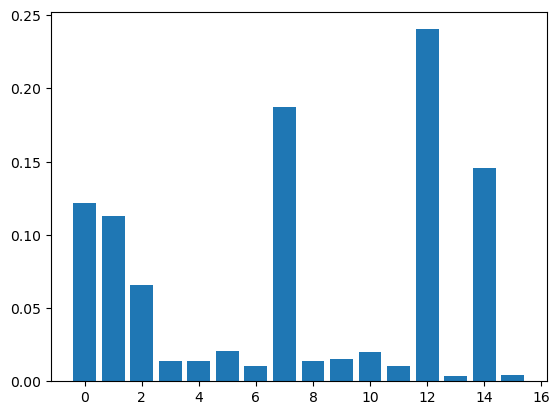

In [82]:
# get importance
importance = grid_search.best_estimator_.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()


What are features 7 and 12?

In [86]:
c = 0
for i in enumerate(X):
    if c == 7 or c == 12:
        print(i)
    c = c + 1

(7, 'median_income')
(12, 'log_households')


### Show best estimator

In [35]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

### Use best estimator

In [36]:
# auto should be replaced with 1.0 in newer versions or not specified as its the default
best_RFR_model = RandomForestRegressor(bootstrap = True, max_depth= 30, min_samples_leaf= 2, min_samples_split=2, n_estimators =100)
best_RFR_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, min_samples_leaf=2)

### Evaluate

In [37]:
y_pred = best_RFR_model.predict(X_test)
eval_ = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
eval_

,actual,predicted
20323,182000.0,175063.079762
15432,124500.0,162098.231714
7140,224500.0,163794.603571
11305,175900.0,191500.100000
12312,115300.0,151316.734238
...,...,...
4663,350000.0,197432.920238
13329,162000.0,172297.464286
5907,193800.0,212649.993214
13533,119900.0,108391.022222


### Plot actual vs predicted

C:\Users\Lujai\AppData\Local\Temp\ipykernel_25092\1004693589.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

C:\Users\Lujai\AppData\Local\Temp\ipykernel_25092\1004693589.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



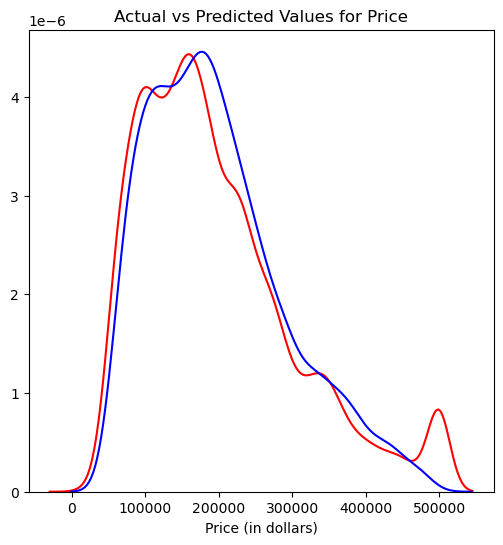

In [54]:
plt.figure(figsize=(6, 6))

# use displot for newer versions
ax1 = sns.distplot(cali['median_house_value'], hist=False, color="r", label="Actual Values")
sns.distplot(y_pred, hist=False, color="b", label="Predicted Values" , ax=ax1)


plt.title('Actual vs Predicted Values for Price')
plt.xlabel('Price (in dollars)')
plt.ylabel('')

plt.show()
plt.close()

### Statistical tests

In [39]:
# check MSE 
mse = mean_squared_error(y_test, y_pred)
mse
# 2450399282.4021482

2450399282.4021482

In [42]:
# check rmse
math.sqrt(mse)
# 49501.507880085315

49501.507880085315

## Conclusion